# Uploading libraries

In [7]:
# Fundamental libraries

import os
import random
import time
import copy

# Working libraries
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import wandb
from torch.autograd import Variable
from sklearn.metrics import classification_report
import torch.utils.data as data
import torchvision
from torchvision import transforms
import torchvision.transforms.functional as transform
from PIL import Image
from transformers import AutoImageProcessor, ViTImageProcessor, ViTForImageClassification, ViTConfig, ResNetForImageClassification, ResNetConfig, BeitForImageClassification, BeitConfig, BeitImageProcessor, AutoFeatureExtractor
import torchvision.transforms.functional as TF
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models
import torch.optim as optim
from torch.optim import lr_scheduler
from sklearn.metrics import f1_score
from importlib import reload
import utility
reload(utility)
from utility import load_data, plot_confusion_matrix, plot_average_f1_scores, train_model, get_classification_details, get_hard_disk_path, show_samples, plot_features_importance, visualize_correlation, get_shap

# Evaluation
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay

# Model Recommendations
VGG-16: Despite being relatively deep, VGG-16 can still be effective on smaller datasets, especially when used with transfer learning. Its simplicity and well-understood architecture make it a good starting point.

ResNet-50: ResNet models, especially the shallower ones like ResNet-50, are known for their ability to avoid overfitting through the use of residual connections. This can be beneficial for learning from small datasets.

MobileNet: Designed for mobile and resource-constrained environments, MobileNets are lightweight and efficient, which can be advantageous when training data is limited.

SqueezeNet: This network achieves AlexNet-level accuracy with significantly fewer parameters. Its compact architecture makes it suitable for small datasets and limited computational resources.

# FILE PATHS on local environment

#### Each folder path represent class (label) :

**Folder name - calss name : description**

0 - 0 class : dead

1 - 1 class : empty

2 - 2 class : keep0

3 - 3 class : keep1

4 - 4 class : keep2

5 - 5 class : reseed0

6 - 6 class : reseed1

7 -  7 class : split

In [8]:
# paths for data upload
FILE_PATH = "E:/New_data_Maxim/croped_images/"
TRAIN_FEATURES_PATH_0 = FILE_PATH + 'keep0' 
TRAIN_FEATURES_PATH_1 = FILE_PATH + 'keep1'
TRAIN_FEATURES_PATH_2 = FILE_PATH + 'keep2'
TRAIN_FEATURES_PATH_3 = FILE_PATH + 'reseed0'
TRAIN_FEATURES_PATH_4 = FILE_PATH + 'reseed1'
TRAIN_FEATURES_PATH_5 = FILE_PATH + 'split'

# list with pathe
PATHES_LIST = [TRAIN_FEATURES_PATH_0,TRAIN_FEATURES_PATH_1,TRAIN_FEATURES_PATH_2,TRAIN_FEATURES_PATH_3,TRAIN_FEATURES_PATH_4, TRAIN_FEATURES_PATH_5]

# Data set : train & test

The data was divided into training and testing sets for each class, with a split of 80% for training and 20% for testing, maintaining the same ratio for each class. However, the dataset exhibits an imbalance issue, with one class having a significantly larger number of samples compared to the other class.

In [9]:
labels = ['keep0', 'keep1', 'keep2', 'reseed0', 'reseed1', 'split']
for i, path in enumerate(PATHES_LIST):
    print(path)

E:/New_data_Maxim/croped_images/keep0
E:/New_data_Maxim/croped_images/keep1
E:/New_data_Maxim/croped_images/keep2
E:/New_data_Maxim/croped_images/reseed0
E:/New_data_Maxim/croped_images/reseed1
E:/New_data_Maxim/croped_images/split


In [30]:
class CustomImageDataset_train(Dataset):
    def __init__(self, img_paths, img_labels, transform=None, model_name=None):
        self.img_sort = img_paths
        self.img_labels = img_labels
        self.transform = transform
        self.processor = None

        # Load the processor if a model name is given
        if model_name == "microsoft/resnet-50":
            self.processor = AutoImageProcessor.from_pretrained(model_name)
        if model_name == "microsoft/resnet-18":
            self.processor = AutoFeatureExtractor.from_pretrained(model_name)
        if model_name == "microsoft/beit-base-patch16-224-pt22k-ft22k":
            self.processor = BeitImageProcessor.from_pretrained(model_name)
        if model_name == "google/vit-base-patch16-224":
            self.processor = ViTImageProcessor.from_pretrained(model_name)

        self.original_len = len(self.img_sort)

    def __len__(self):
        return self.original_len * 1

    def __getitem__(self, idx):
        original_idx = idx % self.original_len
        augmentation_index = idx // self.original_len

        # Load image
        img_path = self.img_sort[original_idx]
        try:
            PIL_image = Image.open(img_path).convert("L")

            # The image can be converted to tensor using
            image = transform.to_tensor(PIL_image)
            image = image * 255
            image = image.type(torch.uint8)
        except Exception as e:
            print(f"Error reading image {img_path}: {e}")
            # Handle error (e.g., by skipping this sample or using a default image)
        if image.shape[0] == 1:
            image = image.repeat(3, 1, 1)

        # Apply transformations
        if self.transform:
            image = self.transform(image)

        # Apply augmentations
        image = self.augmentation(image, augmentation_index)

        # Process the image if a processor is set
        if self.processor:
            image = self.processor(images=image, return_tensors="pt").pixel_values.squeeze()

        # Get label
        label = torch.tensor(self.img_labels[original_idx], dtype=torch.long)

        return image, label
        
    def augmentation(self, image, augmentation_index):
        # Random horizontal flipping
        flip_type = augmentation_index % 2  # 0 for horizontal, 1 for vertical
        rotation = (augmentation_index // 2) * 90  # Will give 0, 90, 180, 270

        # Apply flip
        if flip_type == 0:
            image = TF.hflip(image)
        else:
            image = TF.vflip(image)

        # Apply rotation
        image = TF.rotate(image, rotation)

        return image

### Separate data to train and test data with ratio 0.8 in test data

To utilize the CustomImageDataset_test and CustomImageDataset_train, it is necessary to specify the desired transformations for each case, such as Normalize and CenterCrop.

The following code demonstrates how to define the transformations:

For test data transformation using CenterCrop:

In [31]:
class CustomImageDataset_test(Dataset):
    def __init__(self, img_paths, img_labels, transform=None, model_name=None):
        self.img_sort = img_paths   # List of image paths
        self.img_labels = img_labels # Corresponding labels for each image
        self.transform = transform
        self.processor = None

        # Load the processor if a model name is given
        if model_name == "microsoft/resnet-50":
            self.processor = AutoImageProcessor.from_pretrained(model_name)
        if model_name == "microsoft/resnet-18":
            self.processor = AutoFeatureExtractor.from_pretrained(model_name)
        if model_name == "microsoft/beit-base-patch16-224-pt22k-ft22k":
            self.processor = BeitImageProcessor.from_pretrained(model_name)
        if model_name == "google/vit-base-patch16-224":
            self.processor = ViTImageProcessor.from_pretrained(model_name)
        
        self.len = len(self.img_sort)

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        img_path = self.img_sort[idx]
        try:
            PIL_image = Image.open(img_path).convert("L")

            # The image can be converted to tensor using
            image = transform.to_tensor(PIL_image)
            image = image * 255
            image = image.type(torch.uint8)
        except Exception as e:
            print(f"Error reading image {img_path}: {e}")
            # Handle error (e.g., by skipping this sample or using a default image)

        label = torch.tensor(self.img_labels[idx], dtype=torch.long)
        
        if image.shape[0] == 1:
            image = image.repeat(3, 1, 1)
            
        if self.transform:
            image = self.transform(image)

        if self.processor:
            image = self.processor(images=image, return_tensors="pt").pixel_values.squeeze()

        return image, label

In [32]:
class EarlyStopping:
    def __init__(self, patience=7, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                print('Early stopping triggered')
                self.early_stop = True

Training on fold 1/2


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


ResNetForImageClassification(
  (resnet): ResNetModel(
    (embedder): ResNetEmbeddings(
      (embedder): ResNetConvLayer(
        (convolution): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (normalization): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation): ReLU()
      )
      (pooler): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (encoder): ResNetEncoder(
      (stages): ModuleList(
        (0): ResNetStage(
          (layers): Sequential(
            (0): ResNetBottleNeckLayer(
              (shortcut): ResNetShortCut(
                (convolution): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
                (normalization): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              )
              (layer): Sequential(
                (0): ResNetConvLayer(
                  (convolution): Conv2d(64

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


cuda
Epoch 1, Train Loss: 1.4687015462306239, Validation Loss: 1.193419078249179, Accuracy: 53.29744279946164 %
Class 0 F1 Score: 0.7026086956521738
Class 1 F1 Score: 0.4451827242524917
Class 2 F1 Score: 0.0
Class 3 F1 Score: 0.0
Class 4 F1 Score: 0.61
Class 5 F1 Score: 0.1388888888888889
Epoch 2, Train Loss: 1.2182166928886085, Validation Loss: 1.1348758583894338, Accuracy: 57.873485868102286 %
Class 0 F1 Score: 0.6540284360189573
Class 1 F1 Score: 0.5404255319148936
Class 2 F1 Score: 0.0
Class 3 F1 Score: 0.0
Class 4 F1 Score: 0.7894736842105263
Class 5 F1 Score: 0.5263157894736842


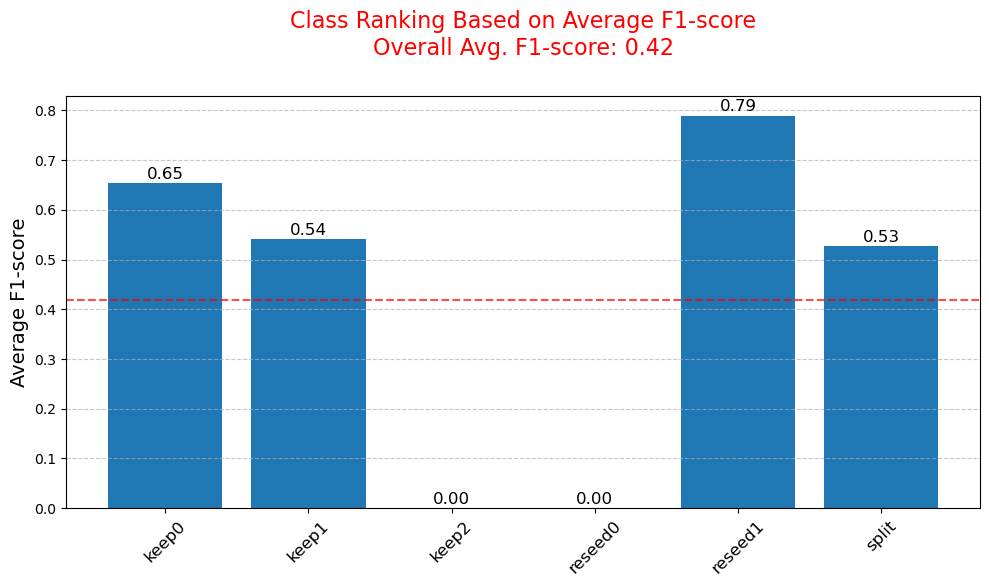

Training on fold 2/2


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


ResNetForImageClassification(
  (resnet): ResNetModel(
    (embedder): ResNetEmbeddings(
      (embedder): ResNetConvLayer(
        (convolution): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (normalization): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation): ReLU()
      )
      (pooler): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (encoder): ResNetEncoder(
      (stages): ModuleList(
        (0): ResNetStage(
          (layers): Sequential(
            (0): ResNetBottleNeckLayer(
              (shortcut): ResNetShortCut(
                (convolution): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
                (normalization): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              )
              (layer): Sequential(
                (0): ResNetConvLayer(
                  (convolution): Conv2d(64

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


cuda
Epoch 1, Train Loss: 1.4184680068364708, Validation Loss: 1.2090043720190904, Accuracy: 51.81695827725437 %
Class 0 F1 Score: 0.6992592592592594
Class 1 F1 Score: 0.013245033112582783
Class 2 F1 Score: 0.3191489361702128
Class 3 F1 Score: 0.0
Class 4 F1 Score: 0.6129870129870131
Class 5 F1 Score: 0.0
Epoch 2, Train Loss: 1.1553614815717101, Validation Loss: 0.9958387966598233, Accuracy: 59.623149394347244 %
Class 0 F1 Score: 0.6812816188870151
Class 1 F1 Score: 0.4275362318840579
Class 2 F1 Score: 0.5692307692307692
Class 3 F1 Score: 0.0
Class 4 F1 Score: 0.773109243697479
Class 5 F1 Score: 0.3368421052631579


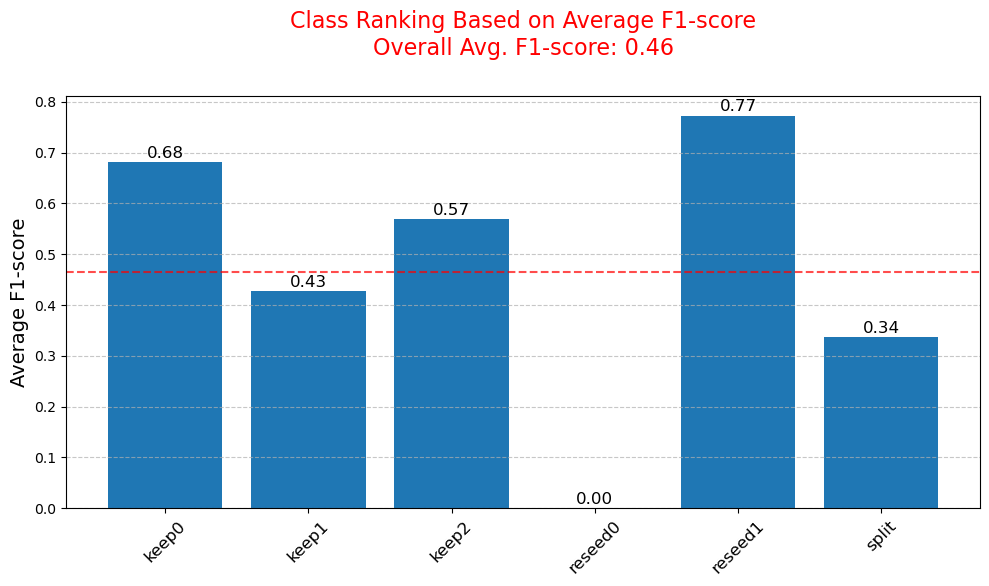

class_0_f1_score,██▁▁██▅▅
class_1_f1_score,▇▇██▁▁▇▇
class_2_f1_score,▁▁▁▁▅▅██
class_3_f1_score,▁▁▁▁▁▁▁▁
class_4_f1_score,▁▁██▁▁▇▇
class_5_f1_score,▃▃██▁▁▅▅
epoch,▁▁██▁▁██
final_accuracy,▁█
fold,▁▁▁▁▁█████
train_loss,█▂▇▁
val_accuracy,▂▆▁█


Training on fold 1/2
ResNetForImageClassification(
  (resnet): ResNetModel(
    (embedder): ResNetEmbeddings(
      (embedder): ResNetConvLayer(
        (convolution): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (normalization): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation): ReLU()
      )
      (pooler): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (encoder): ResNetEncoder(
      (stages): ModuleList(
        (0): ResNetStage(
          (layers): Sequential(
            (0): ResNetBasicLayer(
              (shortcut): Identity()
              (layer): Sequential(
                (0): ResNetConvLayer(
                  (convolution): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
                  (normalization): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                  (activation

The class ConvNextFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ConvNextImageProcessor instead.


cuda
Epoch 1, Train Loss: 1.2817484632294665, Validation Loss: 0.9449337139645572, Accuracy: 62.85329744279946 %
Class 0 F1 Score: 0.7348993288590603
Class 1 F1 Score: 0.3054187192118226
Class 2 F1 Score: 0.5935483870967743
Class 3 F1 Score: 0.0
Class 4 F1 Score: 0.859106529209622
Class 5 F1 Score: 0.0
Epoch 2, Train Loss: 0.9853497647470043, Validation Loss: 0.8097802206313097, Accuracy: 68.90982503364738 %
Class 0 F1 Score: 0.762081784386617
Class 1 F1 Score: 0.5103448275862069
Class 2 F1 Score: 0.6444444444444445
Class 3 F1 Score: 0.0
Class 4 F1 Score: 0.9117647058823528
Class 5 F1 Score: 0.4731182795698924


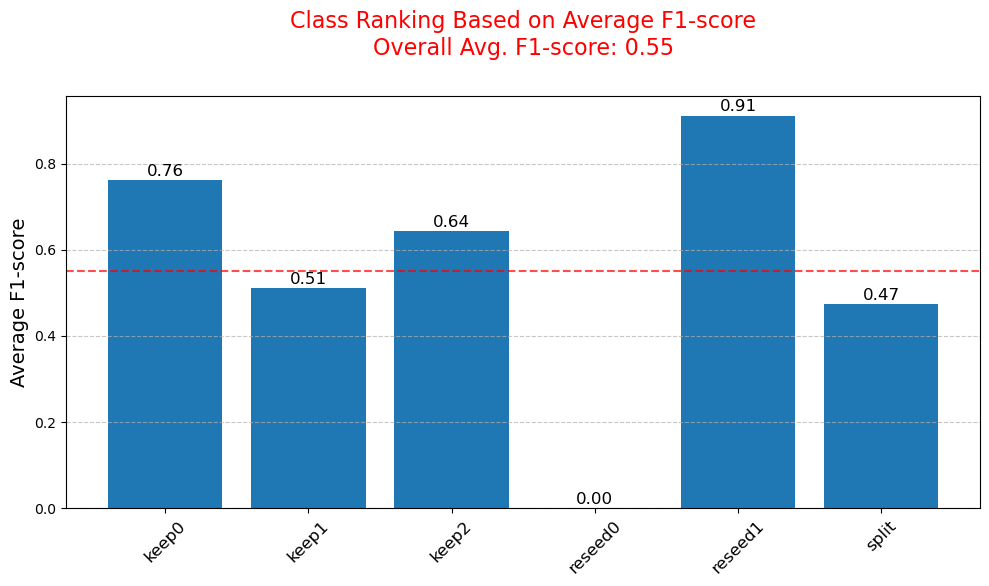

Training on fold 2/2
ResNetForImageClassification(
  (resnet): ResNetModel(
    (embedder): ResNetEmbeddings(
      (embedder): ResNetConvLayer(
        (convolution): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (normalization): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation): ReLU()
      )
      (pooler): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (encoder): ResNetEncoder(
      (stages): ModuleList(
        (0): ResNetStage(
          (layers): Sequential(
            (0): ResNetBasicLayer(
              (shortcut): Identity()
              (layer): Sequential(
                (0): ResNetConvLayer(
                  (convolution): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
                  (normalization): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                  (activation

The class ConvNextFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ConvNextImageProcessor instead.


cuda
Epoch 1, Train Loss: 1.280801099154257, Validation Loss: 0.9689484694847457, Accuracy: 62.85329744279946 %
Class 0 F1 Score: 0.7111913357400723
Class 1 F1 Score: 0.4693140794223827
Class 2 F1 Score: 0.36619718309859156
Class 3 F1 Score: 0.0
Class 4 F1 Score: 0.7650602409638554
Class 5 F1 Score: 0.6624203821656052
Epoch 2, Train Loss: 0.9622628403607235, Validation Loss: 0.909682757999768, Accuracy: 64.33378196500674 %
Class 0 F1 Score: 0.712280701754386
Class 1 F1 Score: 0.4177777777777778
Class 2 F1 Score: 0.6161616161616162
Class 3 F1 Score: 0.0
Class 4 F1 Score: 0.7633136094674556
Class 5 F1 Score: 0.5801526717557252


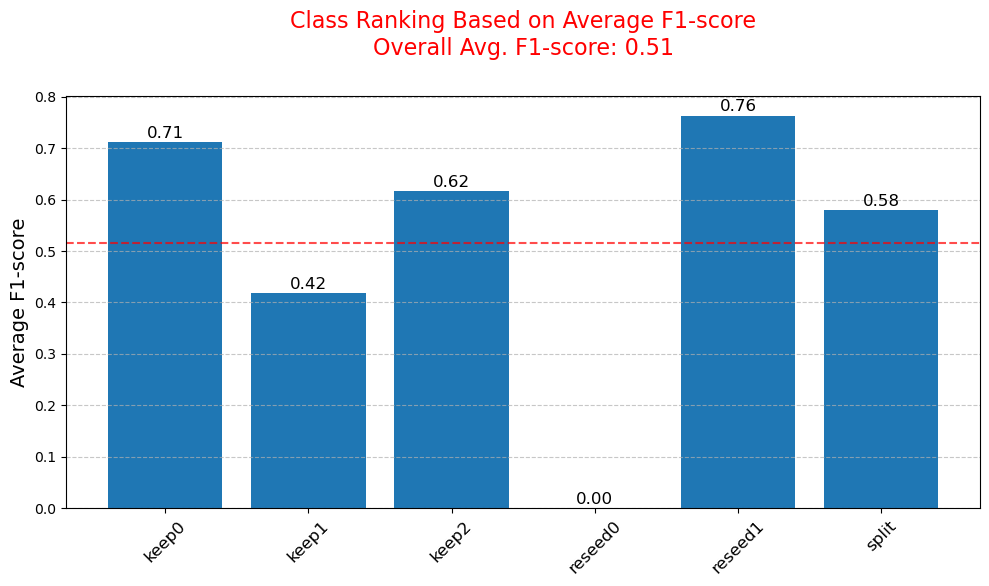

class_0_f1_score,▄▄██▁▁▁▁
class_1_f1_score,▁▁██▇▇▅▅
class_2_f1_score,▇▇██▁▁▇▇
class_3_f1_score,▁▁▁▁▁▁▁▁
class_4_f1_score,▆▆██▁▁▁▁
class_5_f1_score,▁▁▆▆██▇▇
epoch,▁▁██▁▁██
final_accuracy,█▁
fold,▁▁▁▁▁█████
train_loss,█▂█▁
val_accuracy,▁█▁▃


Training on fold 1/2
BeitForImageClassification(
  (beit): BeitModel(
    (embeddings): BeitEmbeddings(
      (patch_embeddings): BeitPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): BeitEncoder(
      (layer): ModuleList(
        (0): BeitLayer(
          (attention): BeitAttention(
            (attention): BeitSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=False)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
              (relative_position_bias): BeitRelativePositionBias()
            )
            (output): BeitSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
     

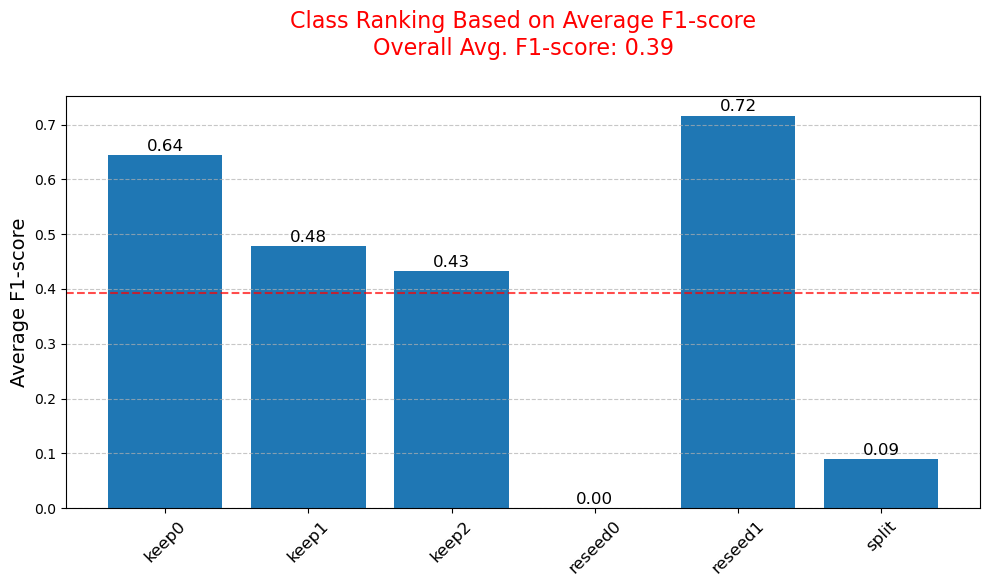

Training on fold 2/2
BeitForImageClassification(
  (beit): BeitModel(
    (embeddings): BeitEmbeddings(
      (patch_embeddings): BeitPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): BeitEncoder(
      (layer): ModuleList(
        (0): BeitLayer(
          (attention): BeitAttention(
            (attention): BeitSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=False)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
              (relative_position_bias): BeitRelativePositionBias()
            )
            (output): BeitSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
     

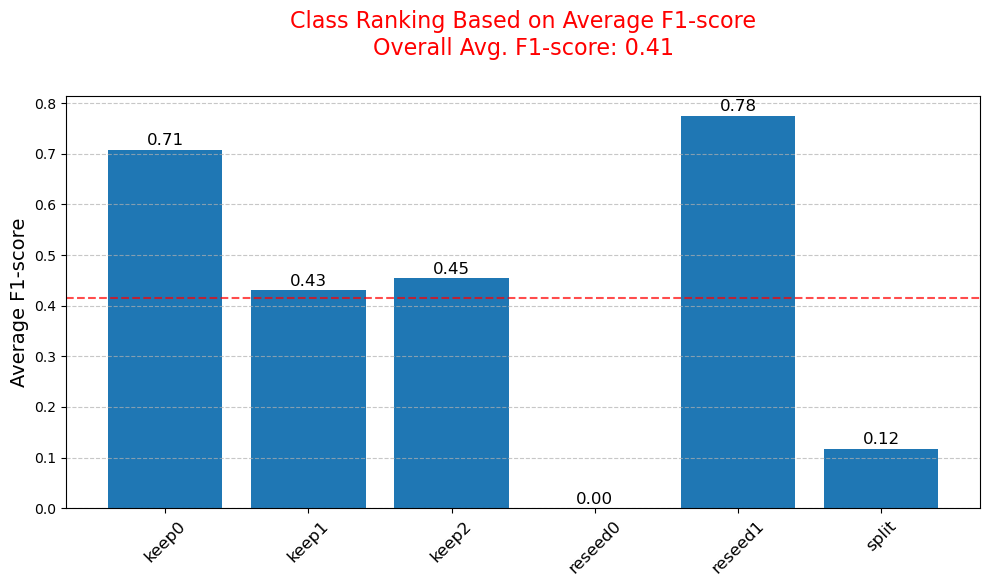

class_0_f1_score,▁▁▇▇▅▅██
class_1_f1_score,▁▁██▇▇▆▆
class_2_f1_score,▄▄▇▇▁▁██
class_3_f1_score,▁▁▁▁▁▁▁▁
class_4_f1_score,▁▁▆▆▄▄██
class_5_f1_score,▅▅▁▁██▁▁
epoch,▁▁██▁▁██
final_accuracy,▁█
fold,▁▁▁▁▁█████
train_loss,█▂█▁
val_accuracy,▁▆▅█


Training on fold 1/2


AttributeError: 'ViTLayer' object has no attribute 'layers'

In [35]:
import torch
import wandb
from sklearn.metrics import f1_score
from torch.utils.data import DataLoader
from sklearn.model_selection import StratifiedKFold
import csv
from torch.optim.lr_scheduler import ReduceLROnPlateau

model_names = ["microsoft/resnet-50", "microsoft/resnet-18", "microsoft/beit-base-patch16-224-pt22k-ft22k", "google/vit-base-patch16-224"]

for model_name in model_names:
    # Initialize a new wandb run
    wandb.init(project="organoid_classification", entity="laurent-gurtler")

    num_epochs = 2
    learning_rate = 5e-5
    batch_size = 4
    k_folds = 2
    weight_decay = 1e-5

    config = wandb.config
    config.learning_rate = learning_rate
    config.batch_size = batch_size
    config.num_epochs = num_epochs
    config.k_folds = k_folds
    config.weight_decay = weight_decay


    all_labels_list = ['keep0', 'keep1', 'keep2', 'reseed0', 'reseed1', 'split']

    all_fold_f1_scores = []
    num_labels = len(all_labels_list)  # The number of unique labels/classes in your dataset

    # Assuming PATHES_LIST contains paths to your different class directories
    img_labels = []
    img_sort = []
    for i, img_dir in enumerate(PATHES_LIST):
        img_files = sorted([f for f in os.listdir(img_dir) if f.endswith(".png")])
        img_labels.extend([i] * len(img_files))  # Labels for each image
        img_sort.extend([os.path.join(img_dir, f) for f in img_files])  # Paths for each image

    # Convert img_sort to a numpy array for easier indexing
    img_sort = np.array(img_sort)

    # Initialize StratifiedKFold
    kf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

    # Convert img_labels to numpy array for StratifiedKFold
    img_labels = np.array(img_labels)

    for fold, (train_idx, val_idx) in enumerate(kf.split(img_sort, img_labels)):
        print(f"Training on fold {fold+1}/{k_folds}")
        if "beit" in model_name:
            config = BeitConfig.from_pretrained(model_name, num_labels=num_labels)
            model = BeitForImageClassification(config)
            last_stage = model.beit.encoder.layer[-1]
            # Freeze all layers first
            for param in model.parameters():
                param.requires_grad = False
            # Access the last N layers of the BEiT encoder
            for layer in model.beit.encoder.layer[-3:]:
                for param in layer.parameters():
                    param.requires_grad = True

        elif "resnet" in model_name:
            config = ResNetConfig.from_pretrained(model_name, num_labels=num_labels)
            model = ResNetForImageClassification(config)
            last_stage = model.resnet.encoder.stages[-1]
            # Freeze all layers first
            for param in model.parameters():
                param.requires_grad = False
            for layer in last_stage.layers:
                for param in layer.parameters():
                    param.requires_grad = True

        elif "vit" in model_name:
            config = ViTConfig.from_pretrained(model_name, num_labels=num_labels)
            model = ViTForImageClassification(config)
            last_stage = model.vit.encoder.layer[-1]
            # Freeze all layers first
            for param in model.parameters():
                param.requires_grad = False
            for layer in model.vit.encoder.layer[-3:]:
                for param in layer.parameters():
                    param.requires_grad = True

        print(model)

        criterion = torch.nn.CrossEntropyLoss()
        # Create a list to hold the parameters you want to optimize
        params_to_optimize = [{'params': last_stage.parameters()}, 
                            {'params': model.classifier.parameters()}]
        

        # Create the optimizer with the specified parameters
        optimizer = optim.Adam(params_to_optimize, lr=learning_rate, weight_decay=weight_decay)

        scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

        early_stopping = EarlyStopping(patience=5, min_delta=0.001)

        # Split data into training and validation for this fold
        train_data = img_sort[train_idx]
        val_data = img_sort[val_idx]

        # Create datasets for this fold
        train_dataset = CustomImageDataset_train(train_data, img_labels[train_idx], 
                                                transform=False, 
                                                model_name=model_name)
        test_dataset = CustomImageDataset_test(val_data, img_labels[val_idx], 
                                            transform=False, 
                                            model_name=model_name)
        

        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(device)
        model.to(device)

        wandb.watch(model, criterion, log="all", log_freq=10)

        epoch_f1_scores_dict_list = []

        num_images_displayed = 0

        for epoch in range(num_epochs):
            model.train()
            running_loss = 0.0
            for images, labels in train_loader:
                images = images.to(device)
                labels = labels.to(device)  # Convert labels to torch.long
                optimizer.zero_grad()
                outputs = model(images).logits
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
            
            wandb.log({"fold": fold+1, "epoch": epoch, "train_loss": running_loss/len(train_loader)})

            # Validation phase
            model.eval()
            all_labels = []
            all_predictions = []
            validation_loss = 0.0
            correct = 0
            total = 0

            with torch.no_grad():
                for images, labels in test_loader:
                    images = images.to(device)
                    labels = labels.to(device)
                    outputs = model(images).logits
                    predicted = outputs.argmax(dim=1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
                    loss = criterion(outputs, labels)
                    validation_loss += loss.item()

                    if early_stopping.early_stop:
                        print("Stopping training")
                        break

                    # Move the labels and predictions to CPU for sklearn metrics
                    all_labels.extend(labels.cpu().numpy())
                    all_predictions.extend(predicted.cpu().numpy())
                # After processing all validation data
                scheduler.step(validation_loss)
                early_stopping(validation_loss)

                if early_stopping.early_stop:
                    print("Stopping training")
                    break
            # Calculate accuracy and F1 score
            accuracy = 100 * correct / total
            f1_scores = f1_score(all_labels, all_predictions, average=None, zero_division=0)  # This will give you an array of F1 scores per class
            # Check if the length of F1 scores matches the number of labels
            if len(f1_scores) != len(all_labels_list):
                print(f"Warning: Number of F1 scores ({len(f1_scores)}) does not match number of classes ({len(all_labels_list)})")
                # Trim the list of F1 scores to match the number of classes, if necessary
                f1_scores = f1_scores[:len(all_labels_list)]

            # Create a dictionary of class labels and their corresponding F1 scores
            f1_scores_dict = {all_labels_list[idx]: f1 for idx, f1 in enumerate(f1_scores)}
            epoch_f1_scores_dict_list.append(f1_scores_dict)

            # It might be useful to also get the classification report for all metrics
            classification_rep = classification_report(all_labels, all_predictions, output_dict=True, zero_division=0)

            # Logging the individual F1 scores
            for idx, f1 in enumerate(f1_scores):
                wandb.log({f"class_{idx}_f1_score": f1})


            wandb.log({"fold": fold+1, "epoch": epoch, "val_loss": validation_loss/len(test_loader), "val_accuracy": accuracy})

            # Print statistics for each class
            print(f"Epoch {epoch+1}, Train Loss: {running_loss/len(train_loader)}, "
                f"Validation Loss: {validation_loss/len(test_loader)}, Accuracy: {accuracy} %")
            for idx, f1 in enumerate(f1_scores):
                print(f"Class {idx} F1 Score: {f1}")

            for idx, f1 in enumerate(f1_scores):
                wandb.log({f"class_{idx}_f1_score": f1})

        # Access the F1-scores for the last epoch
            # Access the F1-scores for the last epoch of this fold
        last_epoch_f1_scores = epoch_f1_scores_dict_list[-1]

        # Append model name, fold number, and F1 scores to the list
        fold_data = {"model_name": model_name, "fold": fold + 1}
        fold_data.update(last_epoch_f1_scores)
        all_fold_f1_scores.append(fold_data)

        # Clear the epoch_f1_scores_dict_list for the next fold
        epoch_f1_scores_dict_list.clear()

        # The last_epoch_f1_scores already contains the F1 scores for each class from the last epoch
        # Optionally, you can directly plot these scores if needed
        plot_average_f1_scores(all_labels_list, last_epoch_f1_scores)


        # After the loop, you may want to log the overall performance
        wandb.log({
            "fold": fold+1, "final_accuracy": accuracy,
            "fold": fold+1, "final_f1_scores": f1_scores.tolist(),  # Convert to list if necessary
            "fold": fold+1, "final_classification_report": classification_rep
        })

        csv_filename = FILE_PATH + 'f1_scores_per_fold.csv'
        existing_data = []

        # Read existing data
        if os.path.exists(csv_filename):
            with open(csv_filename, 'r') as file:
                reader = csv.DictReader(file)
                existing_data = [row for row in reader]

        # Update or append new data
        for new_data in all_fold_f1_scores:
            model_found = False
            for existing_row in existing_data:
                if existing_row['model_name'] == new_data['model_name'] and existing_row['fold'] == str(new_data['fold']):
                    # Update existing row with new data
                    for key, value in new_data.items():
                        existing_row[key] = value
                    model_found = True
                    break
            if not model_found:
                # Convert numeric values to strings for CSV writing
                new_data_string = {k: str(v) for k, v in new_data.items()}
                existing_data.append(new_data_string)

        # Write updated data back to CSV
        header = ['model_name', 'fold'] + all_labels_list

        with open(csv_filename, 'w', newline='') as file:
            writer = csv.DictWriter(file, fieldnames=header)
            writer.writeheader()
            for data_row in existing_data:
                writer.writerow(data_row)

    # Close the wandb run
    wandb.finish()


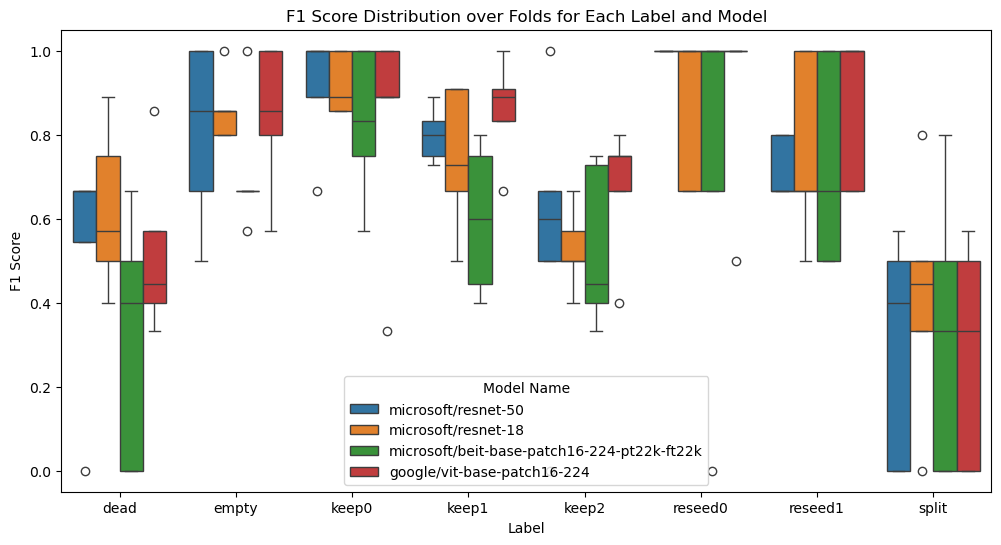

In [29]:
import seaborn as sns

df = pd.read_csv(csv_filename)
df_long = df.melt(id_vars=['model_name', 'fold'], 
                  value_vars=all_labels_list,  # list all your label columns here
                  var_name='label', value_name='f1_score')
# Creating a boxplot for each label within each model
plt.figure(figsize=(12, 6))

# You might need to adjust the size of the figure based on the number of models and labels
sns.boxplot(x='label', y='f1_score', hue='model_name', data=df_long)

plt.title('F1 Score Distribution over Folds for Each Label and Model')
plt.xlabel('Label')
plt.ylabel('F1 Score')
plt.legend(title='Model Name')
plt.show()